# Introductory Course to Image Analysis in Life Science

**Hui Li**  
[GitHub Profile](https://github.com/Huili61)  
Doctoral Student in Machine Learning, Precision Medicine and Diagnostics  
**Chalmers University of Technology**  
Email: hui.li@chalmers.se | lihui61ui@gamil.com

---

### Final Exam – 2024

In this thesis, I developed an image analysis workflow to:

1. **Segment** the nucleus and heterochromatin areas.
2. **Count** the Nuclear Pore Complex (NPC) objects.
3. **Measure** the total area and average fluorescence of the regions of interest (ROI).
4. **Compare** the differences of selected variables across three time conditions: 18d, 28d, and 37d.


### Workflow Overview

Nuclei outlines were segmented through morphological operations to measure the quantity and average fluorescence of NPCs.

After running the script [nucleus.ijm.ijm](./nucleus.ijm.ijm) and this Jupyter Notebook, I extracted the following variables from images:

- **Nucleus Area** (`nucleus_area`): Segmented from channel 3 (DNA channel).
- **Heterochromatin Area** (`hetero_area`): High-intensity regions within nucleus on channel 3.
- **Heterochromatin Ratio** (`hetero_ratio`): Ratio of heterochromatin to the total nuclear area, computed by (`hetero_area / nucleus_area`).
- **Nuclear Average Intensity** (`nucleus_mean_intensity`): Average intensity of nucleus.
- **Heterochromatin Average Intensity** (`hetero_mean_intensity`): Average intensity of heterochromatin.
- **NPC Count** (`npc_count`): Number of NPC objects on nuclear membrane (channel 1).
- **NPC Average Fluorescence** (`npc_mean_fluorescence`): Average fluorescence of NPC objects on nuclear membrane.
- **Time Conditions** (`time`): Time points for comparison: 18d, 28d, and 37d.

The differences of these variables across three time conditions: **18d**, **28d**, and **37d** were illustrated in this Jupyter Notebook.

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# path
output_dir = "C:/Users/lihu/Desktop/homework/output/"
original_table = 'results0.csv'
new_table = 'results.csv'

# read table
df = pd.read_csv(os.path.join(output_dir,original_table))

# extract time
df.loc[df['file_name'].str.contains('18d'), 'time'] = '18d'
df.loc[df['file_name'].str.contains('28d'), 'time'] = '28d'
df.loc[df['file_name'].str.contains('37d'), 'time'] = '37d'

# calculate the ratio of heterochromatin_area/nucleus_area
df['hetero_ratio'] = (df['hetero_area'] / df['nucleus_area']) * 100
df.drop([' '], axis=1, inplace=True)

# save
df.to_csv(os.path.join(output_dir,new_table),index=None)
df.sample(5)


,file_name,nucleus_area,hetero_area,nucleus_mean_intensity,hetero_mean_intensity,npc_count,npc_mean_fluorescence,time,hetero_ratio
13,AC16_Rep1_28d24h_HNRNPC488_NUP594_05_SIR_THR_A...,351.932000,1.063330e+02,2043.454,2971.701,165,2297.117,28d,30.214075
0,AC16_Rep1_18d24h_HNRNPC488_NUP594_01_SIR_THR_A...,274946.000000,6.190100e+04,2252.013,3388.561,124,3645.471,18d,22.513875
25,AC16_Rep1_37d_HNRNPC488_NUP594_13_SIR_THR_ALN-...,0.000004,1.198000e-06,2332.353,3315.786,130,3832.272,37d,31.642895
9,AC16_Rep1_18d24h_HNRNPC488_NUP594_19_SIR_THR_A...,0.000004,1.145000e-06,8269.306,12275.912,83,6464.126,18d,31.525330
29,AC16_Rep1_37d_HNRNPC488_NUP594_21_SIR_THR_ALN-...,0.000004,9.303000e-07,2355.594,4308.942,123,4305.506,37d,21.440424


In [3]:
def distribution_plot(df, variables, title):
    """Distribution plot: combined histogram and box plot
       histplot: group by 'time' (hue='time'),
       box_pot: x = 'time'
    """
    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
    
    # color
    custom_palette = ['#e41a1c', '#377eb8', '#4daf4a']
    
    # Histogram plot (left)
    sns.histplot(
        data=df,
        x=variables,
        kde=True,
        bins=25,
        hue='time',
        palette=custom_palette,
        alpha=0.2,  # transparency
        edgecolor='white',
        linewidth=1,
        ax=axes[0],
        legend=True,
    )
    # legend
    legend = axes[0].get_legend()
    legend.set_title('Time Period')
    legend._loc = 0  # upper left
    plt.setp(legend.get_title(), fontsize='11', fontweight='bold')
    plt.setp(legend.get_texts(), fontsize='10')

    # Violin plot (middle)
    sns.violinplot(
        data=df, 
        x='time', 
        y=variables,
        ax=axes[1],
        width=0.6,
        palette=custom_palette,
    )

    # Box plot (right)
    sns.boxplot(
        data=df, 
        x='time', 
        y=variables,
        ax=axes[2],
        width=0.6,
        fliersize=3, # outlier size
        linewidth=1.5,
        palette=custom_palette,
    )
  
    # super title
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    # remove axes spines
    sns.despine()
    # Adjust layout and spacing
    plt.subplots_adjust(wspace=0.5)  # Space between the subplots
    plt.tight_layout()
    plt.show()

def statistic_test(df, variables):
    # data
    groups = [group[variables].values for name, group in df.groupby('time')]
    names = [name for name, group in df.groupby('time')]
    # Shapiro-Wilk test for normality
    # statistic close to 1, pvalue > 0.05 => approximately normally distributed.
    print('Shapiro-Wilk test for normality')
    for i in range(len(names)):
        s = stats.shapiro(groups[i])
        print(names[i])
        print(s)
    # statistic test
    for i in range(len(names)):
        for j in reversed(range(len(names))):
            if j > i:
                print('group:',names[i], names[j])
                # homogeneity
                # pvalue > 0.05 => the variances are homogeneous (not significantly different).
                h_test = stats.levene(groups[i], groups[j])
                print(h_test)
                # Independent t-test
                t_test = stats.ttest_ind(groups[i], groups[j])
                print(t_test)

#### 1. Average Intensity of Heterochromatin Area

- The Average Intensity of Heterochromatin Area at 18d, 28d may not be normally distributed. This may due to the small amount of data.

- The Average Intensity of Heterochromatin Area at 37d is normally distributed.

- Changes between 18d and 37d are significant. This may also because that the variances of these two groups (18d and 37d) are not equal (homogeneous).

- The range of average heterochromatin intensity decreased and the mean value of average intensity slightly decreased across three time conditions.

In [4]:
# hetero_mean_intensity distribution
# statistic analysis
statistic_test(df=df,variables='hetero_mean_intensity')

Shapiro-Wilk test for normality
18d
ShapiroResult(statistic=0.6793716712945468, pvalue=0.0002544956677431307)
28d
ShapiroResult(statistic=0.6405317104974532, pvalue=0.00023872665155854237)
37d
ShapiroResult(statistic=0.9694401532184335, pvalue=0.8808211977086778)
group: 18d 37d
LeveneResult(statistic=5.152813003462977, pvalue=0.034418715751314936)
TtestResult(statistic=2.3798491804134336, pvalue=0.027384579229148512, df=20.0)
group: 18d 28d
LeveneResult(statistic=0.07528781613503199, pvalue=0.7864688912503066)
TtestResult(statistic=0.33533047543194977, pvalue=0.7407025753048999, df=21.0)
group: 28d 37d
LeveneResult(statistic=2.857600500190258, pvalue=0.10573398844226363)
TtestResult(statistic=1.7597453544787576, pvalue=0.0930121469317336, df=21.0)


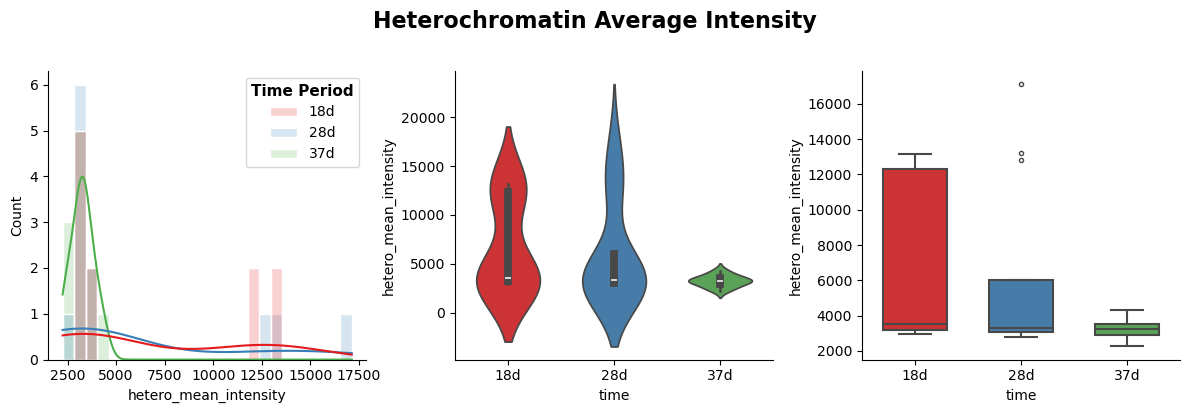

In [5]:
# distribution
distribution_plot(df=df,variables='hetero_mean_intensity',title='Heterochromatin Average Intensity')

#### 2. Heterochromatin/Nuclear Area Ratio

- The Heterochromatin/Nuclear Area Ratio at 18d, 28d, 37d are normally distributed.

- The Heterochromatin/Nuclear Area Ratio increases significantly between 18d and 37d.

- The increase between 18d and 37d indicates that the nucleus may become more compact and could be linked to cellular aging.

In [6]:
# the distribution of heterochromatin/nuclear area ratio
# statistic analysis
statistic_test(df=df,variables='hetero_ratio')


Shapiro-Wilk test for normality
18d
ShapiroResult(statistic=0.9476784106193584, pvalue=0.6144446977178424)
28d
ShapiroResult(statistic=0.9382275525849292, pvalue=0.4754575550568999)
37d
ShapiroResult(statistic=0.9846372739300683, pvalue=0.9864467843307553)
group: 18d 37d
LeveneResult(statistic=2.9347439085012224, pvalue=0.10215266211632654)
TtestResult(statistic=-2.457048455484416, pvalue=0.02326674107805721, df=20.0)
group: 18d 28d
LeveneResult(statistic=0.39644606467922916, pvalue=0.5357213341242355)
TtestResult(statistic=-0.8029210157273233, pvalue=0.4310145734147949, df=21.0)
group: 28d 37d
LeveneResult(statistic=1.1349685303160828, pvalue=0.2988143458841249)
TtestResult(statistic=-1.7121597894260259, pvalue=0.10159671578755702, df=21.0)


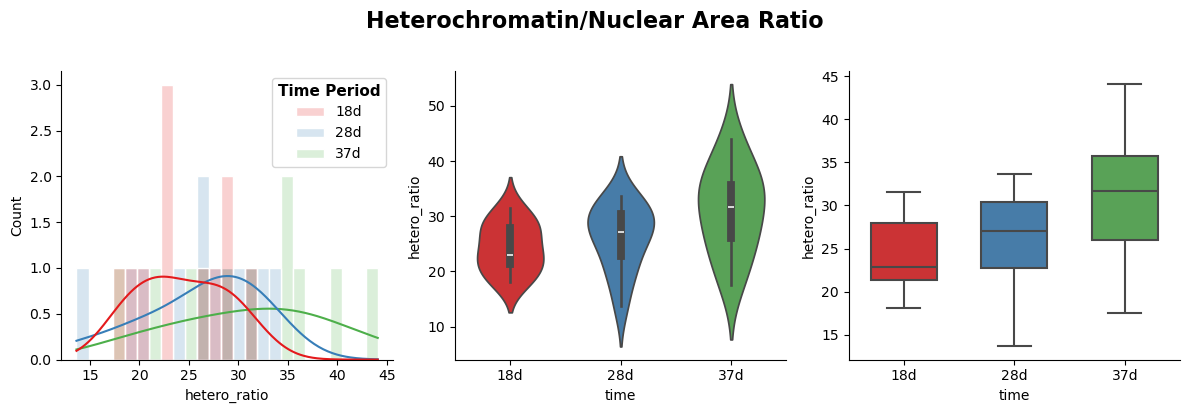

In [7]:
# distribution
distribution_plot(df=df,variables='hetero_ratio',title='Heterochromatin/Nuclear Area Ratio')

#### 3. Quantity of Nuclear Pore Complex (NPC) on the Surface of Nuclear Membrane

- The quantity of NPC at 18d, 37d are normally distributed.

- The quantity of NPC significantly changed between 18d and 37d, showing an increase peaking at 28d and decreased between 28d and 37d.

- The dynamic fluctuation of the quantity of NPC may reflect a dynamic and overall increase in nuclear transport activity and enhanced nuclear-cytoplasmic communication during this time period.

In [8]:
# npc_count distribution
# statistic analysis
statistic_test(df=df,variables='npc_count')

Shapiro-Wilk test for normality
18d
ShapiroResult(statistic=0.9828504770850031, pvalue=0.9799203554530178)
28d
ShapiroResult(statistic=0.8398834119147558, pvalue=0.027597153521980278)
37d
ShapiroResult(statistic=0.8630068753233732, pvalue=0.06298485449351615)
group: 18d 37d
LeveneResult(statistic=4.042351519696685, pvalue=0.0580500125289976)
TtestResult(statistic=-2.840599817005407, pvalue=0.010105810064606244, df=20.0)
group: 18d 28d
LeveneResult(statistic=4.112833121056858, pvalue=0.055434130087141945)
TtestResult(statistic=-5.713867942878498, pvalue=1.1350662780257082e-05, df=21.0)
group: 28d 37d
LeveneResult(statistic=0.01132285164006874, pvalue=0.9162679043746832)
TtestResult(statistic=4.603566943347287, pvalue=0.00015357906867680213, df=21.0)


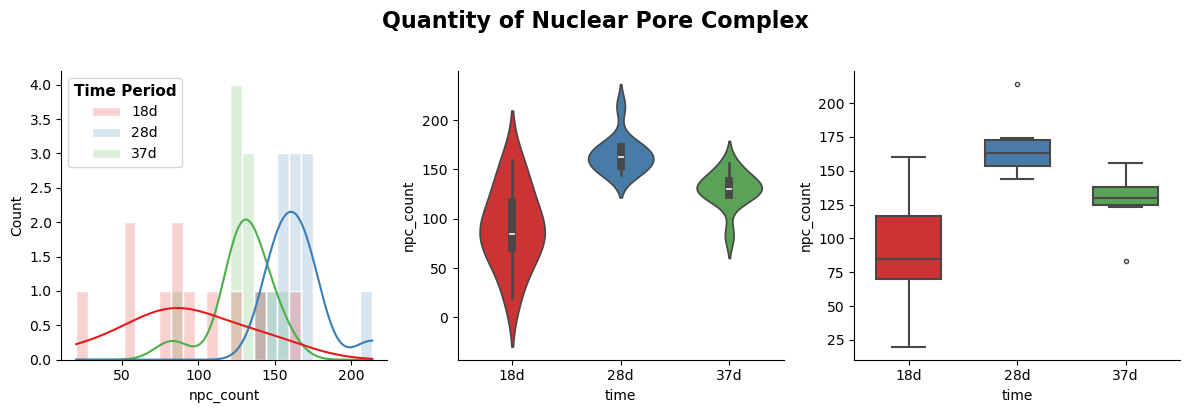

In [9]:
# distribution
distribution_plot(df=df,variables='npc_count',title='Quantity of Nuclear Pore Complex')

#### 4. Average NPC Fluorescence on the Surface of Nuclear Membrane

- The Average NPC Fluorescence at 18d, 28d, 37d are normally distributed.

- The Average NPC Fluorescence significantly increased between 28d and 37d. 

- This rise between 28d and 37d may indicate that the NPC protein expression was upregulated or the functional activity of nuclear pore complexes was increased during this time.

In [10]:
# npc_mean_fluorescence distribution
# Average NPC Fluorescence on the Surface of Nuclear Membrane
# statistic analysis
statistic_test(df=df,variables='npc_mean_fluorescence')

Shapiro-Wilk test for normality
18d
ShapiroResult(statistic=0.8610400612566669, pvalue=0.05939811398394617)
28d
ShapiroResult(statistic=0.949612265357048, pvalue=0.6313229684697286)
37d
ShapiroResult(statistic=0.9363616699609201, pvalue=0.47871490874629197)
group: 18d 37d
LeveneResult(statistic=9.463929273204622, pvalue=0.005955609060509048)
TtestResult(statistic=2.2427949030470447, pvalue=0.036398980215140334, df=20.0)
group: 18d 28d
LeveneResult(statistic=15.839689397680838, pvalue=0.0006816558186076916)
TtestResult(statistic=4.707562286031823, pvalue=0.00011988931270707766, df=21.0)
group: 28d 37d
LeveneResult(statistic=3.2345274780175326, pvalue=0.08649247907901007)
TtestResult(statistic=-6.889473723534588, pvalue=8.281045398857603e-07, df=21.0)


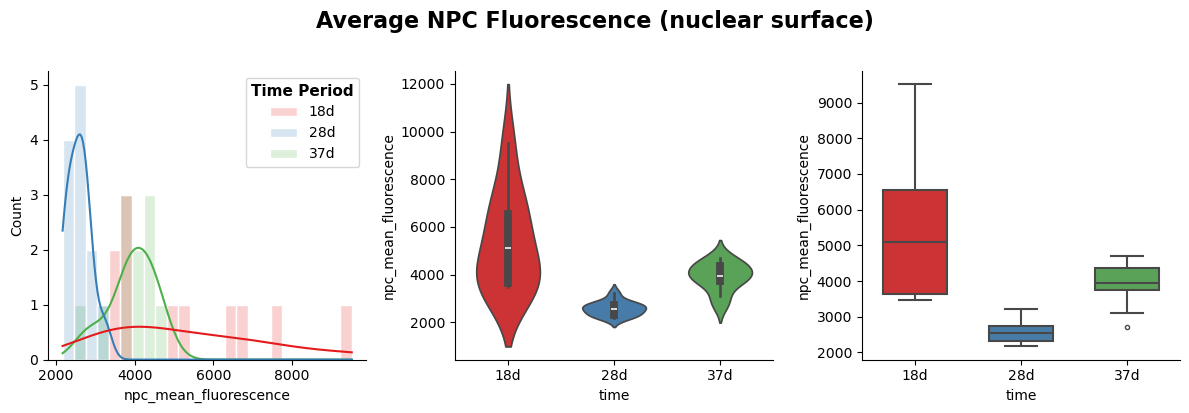

In [11]:
# distribution
distribution_plot(df=df,variables='npc_mean_fluorescence',title='Average NPC Fluorescence (nuclear surface)')